In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def generate_n_body_initial_conditions(n, seed=42, xlim=(-1, 1), ylim=(-1, 1), vlim=(0, 0.5)):
    np.random.seed(seed)
    x = np.random.uniform(*xlim, size=n)
    y = np.zeros(n)
    #y = np.random.uniform(*ylim, size=n)
    #Vx = np.random.uniform(*vlim, size=n)
    Vx = np.zeros(n)
    Vy = np.random.uniform(*vlim, size=n)
    return np.column_stack((x, y, Vx, Vy))

In [3]:
n = 100
initial_conditions = generate_n_body_initial_conditions(n)
print(initial_conditions)


[[-0.25091976  0.          0.          0.01571459]
 [ 0.90142861  0.          0.          0.31820521]
 [ 0.46398788  0.          0.          0.15717799]
 [ 0.19731697  0.          0.          0.25428535]
 [-0.68796272  0.          0.          0.45378324]
 [-0.68801096  0.          0.          0.12464611]
 [-0.88383278  0.          0.          0.20519146]
 [ 0.73235229  0.          0.          0.37777557]
 [ 0.20223002  0.          0.          0.11439908]
 [ 0.41614516  0.          0.          0.03848995]
 [-0.95883101  0.          0.          0.14487573]
 [ 0.9398197   0.          0.          0.08061064]
 [ 0.66488528  0.          0.          0.46484883]
 [-0.57532178  0.          0.          0.40406019]
 [-0.63635007  0.          0.          0.31670188]
 [-0.63319098  0.          0.          0.4357303 ]
 [-0.39151551  0.          0.          0.40183604]
 [ 0.04951286  0.          0.          0.09328503]
 [-0.13610996  0.          0.          0.4462795 ]
 [-0.41754172  0.          0.  

In [4]:
c = 3e8 # скорость света
#G = 6.6e-11
G = 39.478  # Гравитационная постоянная в AU^3 / (Масса_Солнца * год^2)

In [26]:
def n_body_equations(state, t, n, masses):
    """Функция для odeint, описывающая уравнения движения n тел."""
    state = state.reshape(n, 4)  # Преобразуем в (n, 4) массив
    derivatives = np.zeros_like(state)

    for i in range(n):
        # if masses[i] == 0:
        #    continue
        
        xi, yi, vxi, vyi = state[i]
        derivatives[i, 0] = vxi
        derivatives[i, 1] = vyi
        ax, ay = 0, 0
        
        for j in range(n):
            if i != j and j :#and masses[j] > 0:
                xj, yj, _, _ = state[j]
                dx, dy = xj - xi, yj - yi
                r = np.hypot(dx, dy) + 1e-5
                a = G * masses[j] / r**3
                
                # if  a  > 0.01 * c :  # Объединение тел 
                #     state[i, 0:2] = (masses[i] * state[i, 0:2] + masses[j] * state[j, 0:2]) / (masses[i] + masses[j])  # Центр масс
                #     state[i, 2:4] = (masses[i] * state[i, 2:4] + masses[j] * state[j, 2:4]) / (masses[i] + masses[j])  # Новая скорость
                #     masses[i] += masses[j]  # Новая масса
                #     masses[j] = 0
                #     continue

                ax += a * dx
                ay += a * dy
        
        derivatives[i, 2] = ax
        derivatives[i, 3] = ay

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=1, dt=0.01):
    """Решает задачу n тел и возвращает траектории."""
    t = np.arange(0, t_max, dt)
    sol = odeint(n_body_equations, initial_conditions.flatten(), t, args=(n, masses))
    return t, sol.reshape(-1, n, 4)  # Преобразуем в (timesteps, n, 4)

In [ ]:
n = 50
masses = 1e9 * np.ones(n)
seed = 42
initial_conditions = generate_n_body_initial_conditions(n, seed)

# Решение системы
t, trajectories = solve_n_body(n, masses, initial_conditions,t_max=1)

# Пример вывода координат первого тела
for i in range(n):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1])

#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Траектории движения тел")
plt.show()

In [2]:
# Массы (в массах Солнца) и радиусы орбит (в а.е.)
bodies = {
    "Sun": (1.0, 0.0),
    "Mercury": (1.65e-7, 0.39),
    "Venus": (2.45e-6, 0.72),
    "Earth": (3.00e-6, 1.00),
    "Mars": (3.2e-7, 1.52),
    "Jupiter": (9.55e-4, 5.20),
    #"Saturn": (2.86e-4, 9.58),
    #"Uranus": (4.37e-5, 19.22),
    #"Neptune": (5.15e-5, 30.05),
}

# Количество тел
n = len(bodies)

# Формируем массив масс и начальные условия
masses = np.array([bodies[planet][0] for planet in bodies])

# Начальные условия: (x, y, Vx, Vy)
initial_conditions = []
for i, (planet, (mass, r)) in enumerate(bodies.items()):
    x = r
    y = 0
    Vx = 0
    Vy = np.sqrt(G * masses[0] / r) if planet != "Sun" else 0  # Только планеты имеют орбитальную скорость
    initial_conditions.append([x, y, Vx, Vy])

initial_conditions = np.array(initial_conditions)

t, trajectories = solve_n_body(n, masses, initial_conditions, t_max=10)

# Визуализация
plt.figure(figsize=(10, 10))
for i, planet in enumerate(bodies.keys()):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], label=planet)

plt.scatter(0, 0, color='yellow', s=50, label="Sun")
plt.legend()
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Траектории планет в плоскости")
plt.grid()
plt.show()

NameError: name 'np' is not defined

In [4]:
G = 1  # Гравитационная постоянная (в условных единицах)
merge_threshold = 0.015  # Пороговое расстояние для объединения тел

def compute_accelerations(positions, masses):
    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    accelerations[i] += G * masses[j] * r_vec / r**3
    return accelerations

def merge_bodies(positions, velocities, masses):
    n = len(masses)
    
    for i in range(n):
        if masses[i] == 0:
            continue
        for j in range(i + 1, n):
            if masses[j] == 0:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < merge_threshold:
                total_mass = masses[i] + masses[j]
                positions[i] = (masses[i] * positions[i] + masses[j] * positions[j]) / total_mass
                velocities[i] = (masses[i] * velocities[i] + masses[j] * velocities[j]) / total_mass
                masses[i] += masses[j]
                velocities[i] = 0
                masses[j] = 0
                break
    
    return positions, velocities, masses

def verlet_integration(n, masses, positions, velocities, dt, steps):
    positions_history = [positions.copy()]
    accelerations = compute_accelerations(positions, masses)
    
    for _ in range(steps):
        new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
        new_accelerations = compute_accelerations(new_positions, masses)
        new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
        
        positions, velocities, masses = merge_bodies(new_positions, new_velocities, masses)
        accelerations = compute_accelerations(positions, masses)
        positions_history.append(positions.copy())
    
    return np.array(positions_history)

# Пример использования
n = 5
dt = 0.01
steps = 13
masses = np.ones(n)
initial_conditions = generate_n_body_initial_conditions(n)
positions = initial_conditions[:, :2]
velocities = initial_conditions[:, 2:]

trajectories = verlet_integration(n, masses, positions, velocities, dt, steps)

# Визуализация
plt.figure(figsize=(10, 10))
for i in range(n):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1])

plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Траектории планет (метод Верле)")
plt.grid()
plt.show()


NameError: name 'generate_n_body_initial_conditions' is not defined

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

G = 39.478  # Гравитационная постоянная в AU^3 / (Масса_Солнца * год^2)

# Массы (в массах Солнца) и радиусы орбит (в а.е.), скорости (в а.е/год)
bodies = {
    "Sun":      (1.0, 0.0, 0.0),
    "Mercury":  (1.65e-7, 0.39, 10.1),
    "Venus":    (2.45e-6, 0.72, 7.4),
    "Earth":    (3.00e-6, 1.00, 6.3),
    "Mars":     (3.2e-7, 1.52, 5.1),
    "Jupiter":  (9.55e-4, 5.20, 2.7),
    "Saturn":   (2.86e-4, 9.58, 2.0),
    "Uranus":   (4.37e-5, 19.22, 1.4),
    "Neptune":  (5.15e-5, 30.05, 1.1),
    "Pluto":    (6.5e-9, 40.05, 0.945),
}

# Количество тел
n = len(bodies)

# Формируем массив масс и начальные условия
masses = np.array([bodies[planet][0] for planet in bodies])

# Начальные условия: (x, y, Vx, Vy)
initial_conditions = []
for i, (planet, (mass, r, V)) in enumerate(bodies.items()):
    x = r
    y = 0
    Vx = 0
    Vy = V #np.sqrt(G * masses[0] / r) if planet != "Sun" else 0  # Только планеты имеют орбитальную скорость
    initial_conditions.append([x, y, Vx, Vy])

initial_conditions = np.array(initial_conditions)

def n_body_equations(state, t, n, masses):
    """Функция для odeint, описывающая уравнения движения n тел."""
    state = state.reshape(n, 4)
    derivatives = np.zeros_like(state)

    n = len(state)
    # Позиции и скорости
    pos = state[:, :2]   # (n, 2)
    vel = state[:, 2:]   # (n, 2)

    # Заполняем производные скоростей (dx/dt = vx, dy/dt = vy)
    derivatives[:, :2] = vel

    # Расчёт ускорений
    for i in range(n):
        r_i = pos[i]  # (2,)
        diff = pos - r_i  # (n, 2)
        dist = np.linalg.norm(diff, axis=1) + 1e-5  # (n,)
        
        # Удаляем вклад тела i в суммирование
        mask = np.arange(n) != i
        diff = diff[mask]             # (n-1, 2)
        dist = dist[mask]             # (n-1,)
        m = masses[mask]              # (n-1,)

        # Ускорение: G * m / r^3 * dr
        accel = (G * m / dist**3)[:, np.newaxis] * diff  # (n-1, 2)
        total_accel = np.sum(accel, axis=0)

        derivatives[i, 2:] = total_accel

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=50, dt=0.02):
    """Решает задачу n тел и возвращает траектории."""
    t = np.arange(0, t_max, dt)
    sol = odeint(n_body_equations, initial_conditions.flatten(), t, args=(n, masses))
    return t, sol.reshape(-1, n, 4)

# Решение системы
t, trajectories = solve_n_body(n, masses, initial_conditions,t_max=200)

In [7]:
trajectories_copy = np.array(trajectories)
for i, planet in enumerate(bodies.keys()):
    
    if i < 1 :
        continue

    length = np.log(bodies[planet][1] + 3)
   
    trajectories_copy[:,i,0] /= length
    trajectories_copy[:,i,1] /= length

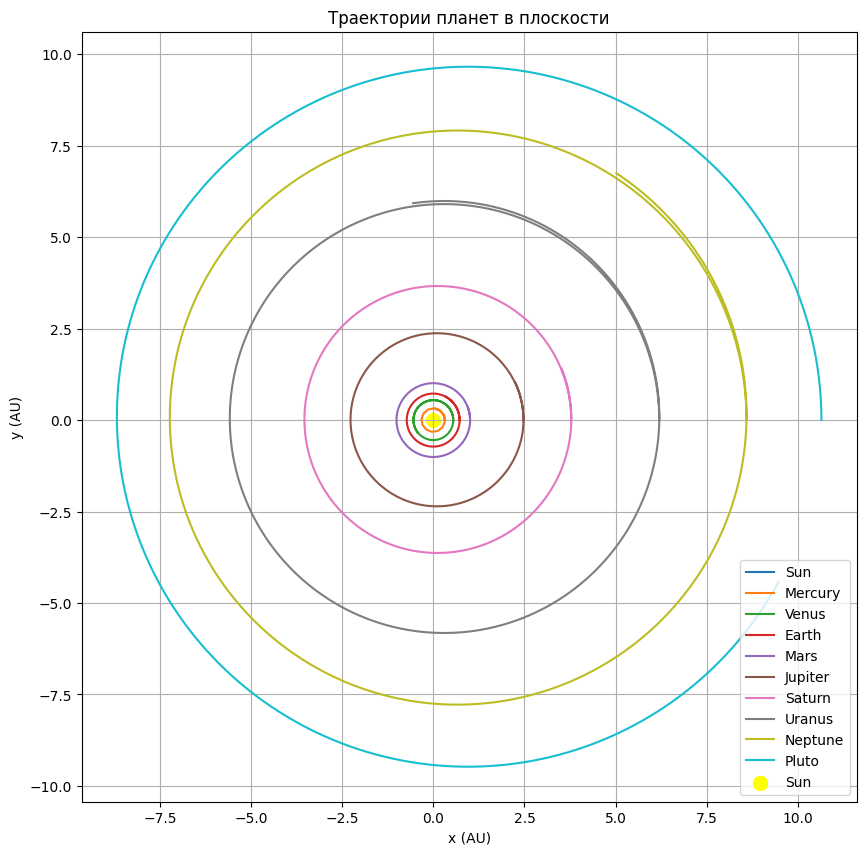

In [8]:
# Визуализация
plt.figure(figsize=(10, 10))
for i, planet in enumerate(bodies.keys()):
    if i == 0:
        plt.plot(trajectories_copy[:1, i, 0], trajectories_copy[:1, i, 1], label=planet)
    elif i == 1:
        plt.plot(trajectories_copy[:16, i, 0], trajectories_copy[:16, i, 1], label=planet)
    elif i == 2:
        plt.plot(trajectories_copy[:50, i, 0], trajectories_copy[:50, i, 1], label=planet)
    elif i == 3:
        plt.plot(trajectories_copy[:60, i, 0], trajectories_copy[:60, i, 1], label=planet)
    elif i == 4:
        plt.plot(trajectories_copy[:100, i, 0], trajectories_copy[:100, i, 1], label=planet)
    elif i == 5:
        plt.plot(trajectories_copy[:600, i, 0], trajectories_copy[:600, i, 1], label=planet)
    elif i == 6:
        plt.plot(trajectories_copy[:1500, i, 0], trajectories_copy[:1500, i, 1], label=planet)
    elif i == 7:
        plt.plot(trajectories_copy[:5000, i, 0], trajectories_copy[:5000, i, 1], label=planet)
    elif i == 8:
        plt.plot(trajectories_copy[:8500, i, 0], trajectories_copy[:8500, i, 1], label=planet)
    else:
        plt.plot(trajectories_copy[:, i, 0], trajectories_copy[:, i, 1], label=planet)

plt.scatter(0, 0, color='yellow', s=100, label="Sun")
plt.legend()
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
#plt.xscale('log')
#plt.yscale('log')
plt.title("Траектории планет в плоскости")
plt.grid()
plt.show()
